In [231]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd

# %% [markdown]
# ## Preprocessing
def get_results(index=-1) -> pd.DataFrame:
    """
    Input:
        index: the index of the results files, defaults to latest file at -1
    """
    # %%
    folder_path = "/Users/oas/Downloads/benchmarking_results"
    # folder_path = "/Users/oas/Documents/VOD/vod/benchmarking_results"
    files = [
        os.path.join(folder_path, file)
        for file in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, file))
    ]
    files.sort()  # Sort the files by name
    newest_file = files[index]  # Pick the newest
    print(newest_file)

    # %%
    df_results = pd.read_csv(newest_file)
    df_results.shape

    # %%
    df_results.query("RecallMean != -1")  # ["Index parameters."].str[-40:]

    # %%
    df_results = df_results.query("Index != 'None'")  # ignore failed runs
    df_results = df_results.query("RecallMean != -1.0")  # ignore failed runs

    # %%
    # this should be empty
    df_results[df_results.benchmarkingMean.isna()]

    # %%
    # extract index information
    df_results["IndexProvider"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[0]
    df_results["IndexType"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[1]

    # %%
    # extract search parameters from parameter string

    df_hnsw_parameters = (
        df_results.query("IndexType == 'HNSW'")["IndexParameters"]
        .str.replace("=", ", ")
        .str.split(", ", expand=True)[[2, 4, 6, 7, 8]]
    )
    df_hnsw_parameters.columns = ["M", "EfConstruction", "EfSearch", "Compression", "Metric"]

    df_ivf_parameters = pd.DataFrame()
    # TODO fix that this makes errors when no IVF are in benchmark
    df_ivf_parameters = (
        df_results.query("IndexType == 'IVF'")["IndexParameters"]
        .str.replace(",", "")
        .str.replace("=", " ")
        .str.split(" ", expand=True)[[2, 3, 4]]
    )
    df_ivf_parameters.columns = ["NPartitions", "Compression", "Metric"]
    ""

    # %%
    # add search parameters to df_results
    df_parameters = df_hnsw_parameters.combine_first(df_ivf_parameters)
    df_results = pd.concat((df_results, df_parameters), axis=1)

    # %%
    df_results.columns = [col[0].upper() + col[1:] for col in df_results.columns]
    df_results.columns
    # %% [markdown]
    
    return df_results

In [232]:
# df = get_results(index=-3) # get the large run on GIST
df = get_results(index=-2) # get the large run on SIFT
df = df.loc[:59]
df_milvus = get_results(index=-1) # get the large run on SIFT
df_milvus.index = df_milvus.index + 60
df = pd.concat([df, df_milvus])

/Users/oas/Downloads/benchmarking_results/2024-03-05-10-20-13.csv
/Users/oas/Downloads/benchmarking_results/2024-03-06-13-45-38.csv


/var/folders/n1/7wj2y4td3hvcbzpx659rrhch0000gn/T/ipykernel_78165/260962909.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["IndexProvider"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[0]
/var/folders/n1/7wj2y4td3hvcbzpx659rrhch0000gn/T/ipykernel_78165/260962909.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["IndexType"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[1]
/var/folders/n1/7wj2y4td3hvcbzpx659rrhch0000gn/T/ipykernel_781

### Effect of IVF sweep

In [233]:
import seaborn as sns

In [234]:
# Function to plot scatterplot and add labels to it
def add_labels(plot, x, y, labels):
    # Adding labels for each point
    for point in range(0, len(x)):
        plot.text(
            x.iloc[point],
            y.iloc[point],
            "  "+labels.iloc[point],
            horizontalalignment="left",
            size="small",
            color="black",
            #weight="semibold",
        )

# IVF

### n partitions sweep

In [235]:
df.iloc[40:67]

,Unnamed: 0,Dataset,Index,IndexParameters,TimerMasterMean,TimerServerStartupMean,TimerBuildIndexMean,SearchSpeedAverage,SearchSpeedP95,RecallMean,...,BenchmarkingMax,BenchmarkingMean,IndexProvider,IndexType,Compression,EfConstruction,EfSearch,M,Metric,NPartitions
57,57,sift-128-euclidean,"index: qdrant HNSW, M=32, ef_construction=32, ...","HNSW, M=32, ef_construction=32, ef_search=16, ...",68.356155,4.741791,58.599492,5.330065,13.529827,0.904948,...,1300.480,1197.325333,qdrant,HNSW,None,32,16,32,L2,NaN
58,58,sift-128-euclidean,"index: qdrant HNSW, M=32, ef_construction=32, ...","HNSW, M=32, ef_construction=32, ef_search=32, ...",67.434128,4.037965,58.381711,5.420763,13.757201,0.900297,...,1302.528,1171.005756,qdrant,HNSW,None,32,32,32,L2,NaN
59,59,sift-128-euclidean,"index: qdrant HNSW, M=32, ef_construction=32, ...","HNSW, M=32, ef_construction=32, ef_search=64, ...",68.029509,4.339538,58.675192,5.598699,14.324821,0.925608,...,1370.112,1184.458419,qdrant,HNSW,None,32,64,32,L2,NaN
60,0,sift-128-euclidean,"index: milvus IVF, n_partition=64, None, L2","IVF, n_partition=64, None, L2",161.984408,91.158141,65.742976,2.320321,2.548022,0.982151,...,1716.708,1203.750538,milvus,IVF,None,NaN,NaN,NaN,L2,64
61,1,sift-128-euclidean,"index: milvus IVF, n_partition=128, None, L2","IVF, n_partition=128, None, L2",165.023545,91.434945,68.507926,2.218690,2.435784,0.991873,...,1727.580,1226.194077,milvus,IVF,None,NaN,NaN,NaN,L2,128
62,2,sift-128-euclidean,"index: milvus IVF, n_partition=256, None, L2","IVF, n_partition=256, None, L2",165.876709,91.942128,68.853711,2.367089,2.621065,0.995921,...,1763.804,1249.281615,milvus,IVF,None,NaN,NaN,NaN,L2,256
63,3,sift-128-euclidean,"index: milvus IVF, n_partition=512, None, L2","IVF, n_partition=512, None, L2",188.140312,101.273602,81.785626,2.617808,3.437749,0.998081,...,3522.008,1751.865933,milvus,IVF,None,NaN,NaN,NaN,L2,512
64,4,sift-128-euclidean,"index: milvus IVF, n_partition=1024, None, L2","IVF, n_partition=1024, None, L2",210.754938,91.788467,113.886073,2.857559,3.806693,0.999030,...,3328.900,1823.883824,milvus,IVF,None,NaN,NaN,NaN,L2,1024
65,5,sift-128-euclidean,"index: milvus IVF, n_partition=2048, None, L2","IVF, n_partition=2048, None, L2",268.749255,101.867774,161.801337,3.588178,4.486139,0.999511,...,2149.064,1920.769800,milvus,IVF,None,NaN,NaN,NaN,L2,2048
66,6,sift-128-euclidean,"index: milvus IVF, n_partition=4096, None, L2","IVF, n_partition=4096, None, L2",394.264325,91.554489,297.609647,4.520539,4.998783,0.999775,...,1424.634,1386.330383,milvus,IVF,None,NaN,NaN,NaN,L2,4096


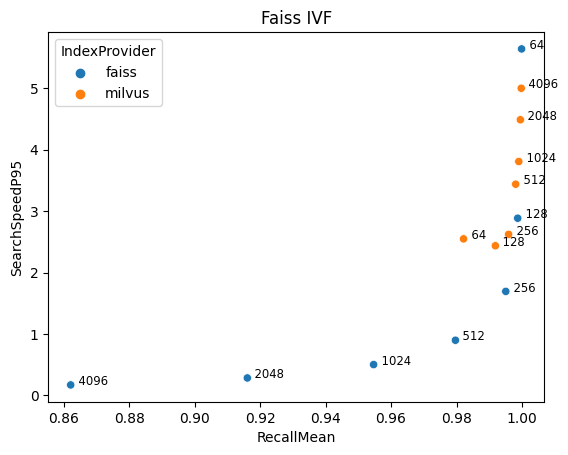

In [236]:
# df_plot = df.query("IndexType == 'IVF'")
df_plot = df.loc[list(range(0,7))+list(range(60,67))]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
hue = df_plot.IndexProvider
labels = df_plot.NPartitions
style = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss IVF")
plt.show()

### n_probe=1 sweep

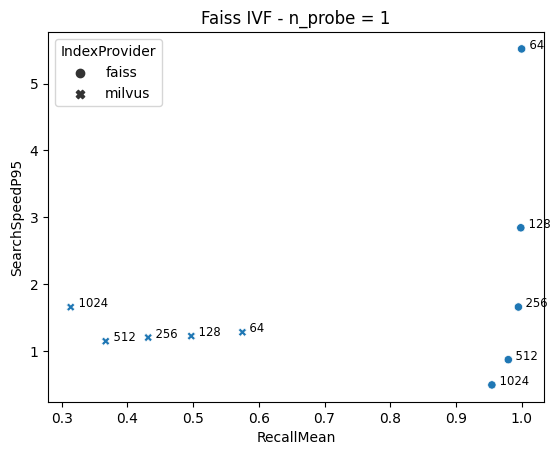

In [237]:
# df_plot = df.query("IndexType == 'IVF'")
# df_plot = df.iloc[7:12]
df_plot = df.loc[list(range(7, 12)) + list(range(67, 72))]

x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.NPartitions
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss IVF - n_probe = 1")
plt.show()

### N probe sweep

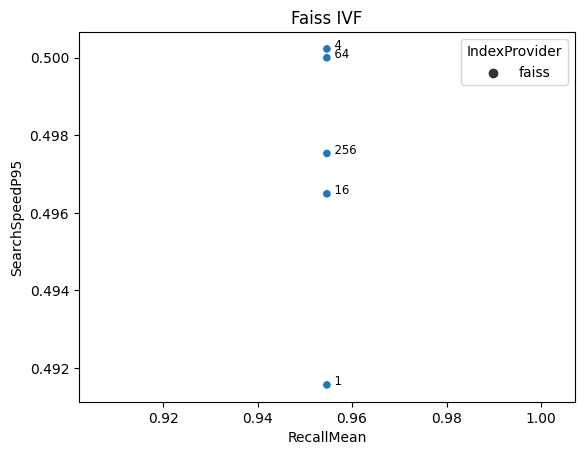

In [238]:
n_probe = pd.Series(["1", "4", "16", "64", "256", "1", "4", "16", "64", "256"])

# df_plot = df.query("IndexType == 'IVF'")
df_plot = df.iloc[12:17]

x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = n_probe
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss IVF")
plt.show()

### N probe sanity check

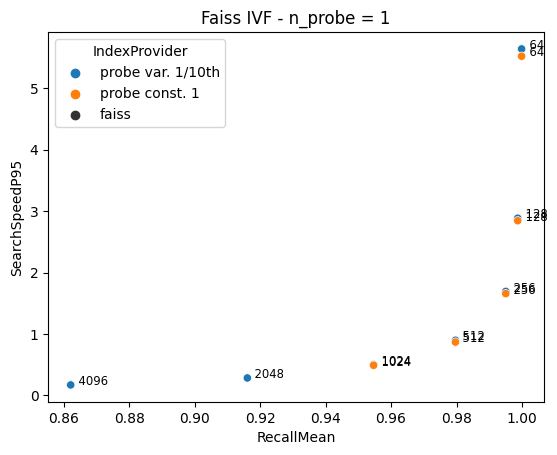

In [239]:
# df_plot = df.query("IndexType == 'IVF'")
df_plot = df.iloc[:12]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.NPartitions
hue = ["probe var. 1/10th"]*7 + ["probe const. 1"]*5

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss IVF - n_probe = 1")
plt.show()

### HNSW faiss M sweep

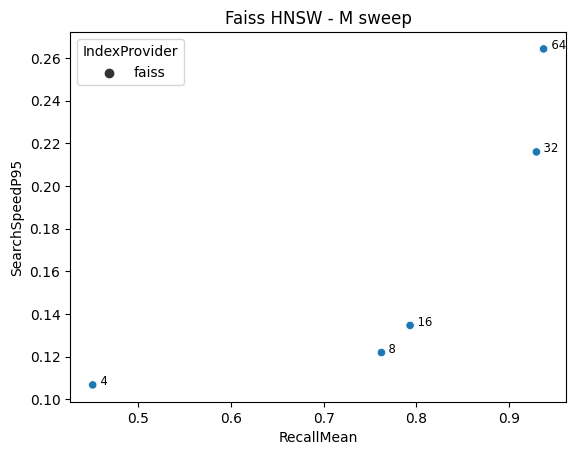

In [240]:
df_plot = df.query("IndexType == 'HNSW' and IndexProvider == 'faiss' and EfSearch == '128'")
# df_plot = df.iloc[:12]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.M
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss HNSW - M sweep")
plt.show()

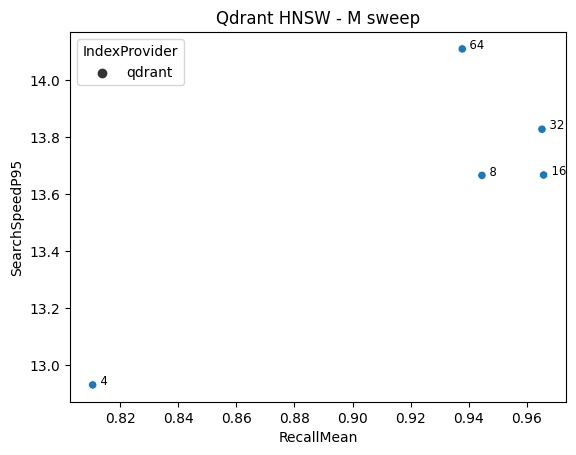

In [241]:
df_plot = df.query("IndexType == 'HNSW' and IndexProvider == 'qdrant' and EfSearch == '128'")
# df_plot = df.iloc[:12]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.M
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Qdrant HNSW - M sweep")
plt.show()

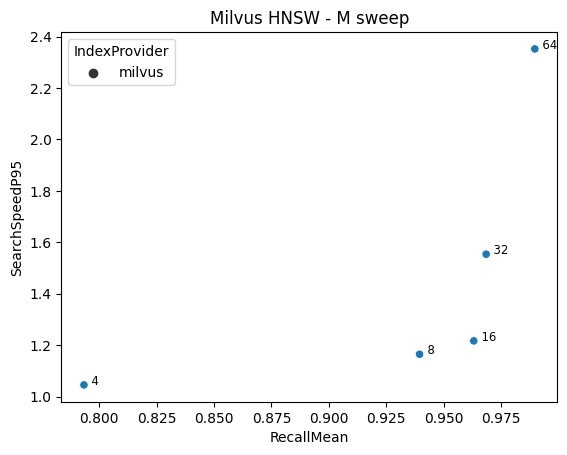

In [242]:
df_plot = df.query("IndexType == 'HNSW' and IndexProvider == 'milvus' and EfSearch == '128'")
# df_plot = df.iloc[:12]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.M
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Milvus HNSW - M sweep")
plt.show()

## HNSW ef sweep

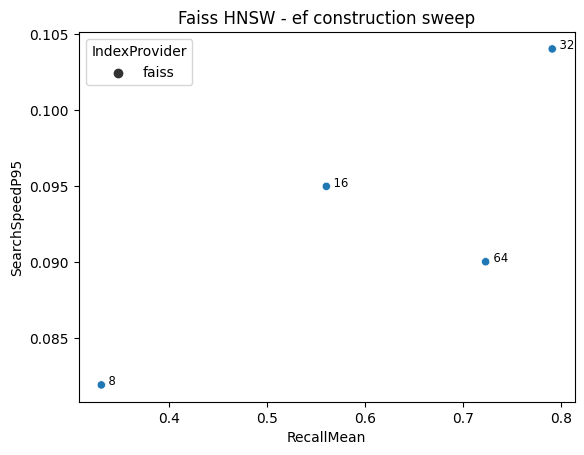

In [243]:
# df_plot = df.query("IndexType == 'HNSW' and IndexProvider == 'faiss' and EfSearch == '128'")
df_plot = df.iloc[22:26]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.EfConstruction
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss HNSW - ef construction sweep")
plt.show()

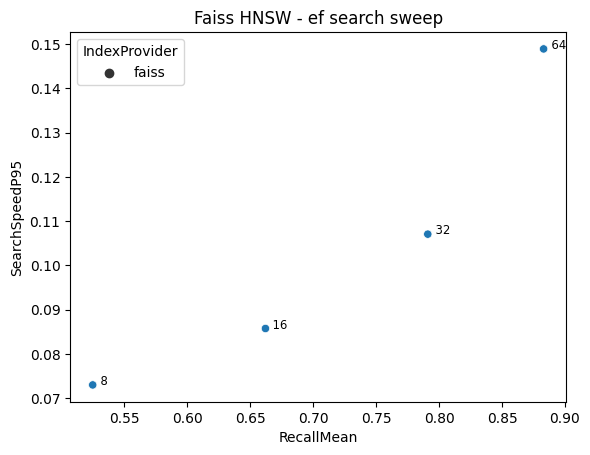

In [244]:
# df_plot = df.query("IndexType == 'HNSW' and IndexProvider == 'faiss' and EfSearch == '128'")
df_plot = df.iloc[26:30]
x = df_plot.RecallMean
y = df_plot.SearchSpeedP95
style = df_plot.IndexProvider
labels = df_plot.EfSearch
hue = None

plot = sns.scatterplot(x=x, y=y, hue=hue, style=style)
add_labels(plot=plot, x=x, y=y, labels=labels)
plt.title("Faiss HNSW - ef search sweep")
plt.show()